In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import PIL.Image as Image1
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
import cv2 
import PIL.Image as Image
%matplotlib inline

Using TensorFlow backend.


In [2]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    ### START CODE HERE ### (≈ 1 line)
    box_scores = box_confidence * box_class_probs
    ### END CODE HERE ###
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    ### START CODE HERE ### (≈ 2 lines)
    box_classes = K.argmax(box_scores, axis= -1)
    box_class_scores = K.max(box_scores, axis = -1,keepdims = False)
    ### END CODE HERE ###
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ### START CODE HERE ### (≈ 1 line)
    filtering_mask = box_class_scores >= threshold
    ### END CODE HERE ###
    
    # Step 4: Apply the mask to scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    ### END CODE ERE ###
    
    return scores, boxes, classes

In [3]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))
    

scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


In [4]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ### START CODE HERE ### (≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_output_size = max_boxes,iou_threshold = iou_threshold)
    ### END CODE HERE ###
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [5]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [34]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.5, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    ### START CODE HERE ### 
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = iou_threshold)
    
    ### END CODE HERE ###
    
    return scores, boxes, classes


In [35]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [36]:
sess = K.get_session()

In [37]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (544., 960.)    

In [38]:
yolo_model = load_model("model_data/yolo.h5")

In [39]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [40]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [41]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [42]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    #image, image_data = preprocess_image( image_file, model_image_size = (608, 608))
    image, image_data = preprocess_image("images/"+image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],feed_dict={yolo_model.input: image_data,K.learning_phase(): 0})
    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

<PIL.Image.Image image mode=RGB size=1280x720 at 0x136C09400>
Found 8 boxes for hrx2.jpg
book 0.43 (966, 42) (1135, 248)
book 0.43 (1071, 192) (1280, 252)
book 0.45 (1078, 139) (1280, 224)
book 0.49 (1050, 237) (1280, 279)
bottle 0.62 (968, 296) (1073, 555)
bottle 0.62 (935, 227) (1052, 455)
book 0.73 (1043, 32) (1280, 182)
laptop 0.85 (103, 300) (452, 459)


/Users/yuminggu/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


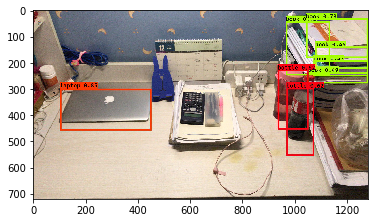

In [26]:

a = "hrx2.jpg"
pic = Image.open("preimages/"+a)
pic = pic.resize((1280,720))
print(pic)
pic.save(os.path.join("images", a), quality = 100)
out_scores, out_boxes, out_classes = predict(sess, a)

Found 7 boxes for out_test.jpg
car 0.55 (883, 345) (960, 375)
car 0.55 (719, 343) (851, 373)
car 0.58 (137, 316) (219, 357)
car 0.62 (570, 330) (688, 372)
car 0.65 (446, 333) (546, 364)
traffic light 0.68 (735, 13) (770, 95)
car 0.73 (333, 320) (425, 365)


/Users/yuminggu/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Found 8 boxes for out_test.jpg
traffic light 0.50 (791, 2) (875, 67)
car 0.52 (555, 331) (685, 370)
traffic light 0.56 (729, 12) (766, 95)
car 0.56 (708, 342) (848, 375)
car 0.59 (123, 316) (210, 357)
car 0.59 (874, 349) (960, 375)
car 0.65 (320, 320) (412, 364)
car 0.70 (427, 332) (520, 362)
Found 7 boxes for out_test.jpg
car 0.51 (538, 329) (662, 375)
traffic light 0.57 (701, 12) (745, 96)
car 0.58 (700, 342) (850, 374)
car 0.58 (103, 318) (184, 355)
car 0.59 (868, 347) (960, 375)
car 0.62 (307, 321) (393, 362)
car 0.65 (417, 332) (523, 364)
Found 6 boxes for out_test.jpg
car 0.54 (524, 328) (653, 370)
car 0.56 (848, 344) (942, 371)
car 0.58 (679, 341) (787, 370)
car 0.63 (91, 319) (177, 352)
car 0.70 (301, 320) (396, 362)
car 0.71 (410, 334) (493, 363)
Found 7 boxes for out_test.jpg
car 0.57 (516, 327) (645, 369)
car 0.59 (670, 340) (793, 370)
car 0.61 (838, 343) (938, 370)
traffic light 0.63 (686, 14) (720, 94)
car 0.67 (77, 315) (166, 354)
car 0.70 (401, 332) (496, 362)
car 0.71 (

Found 4 boxes for out_test.jpg
car 0.50 (694, 375) (737, 399)
car 0.60 (468, 368) (584, 398)
car 0.71 (182, 357) (278, 390)
traffic light 0.74 (482, 54) (517, 140)
Found 5 boxes for out_test.jpg
traffic light 0.54 (341, 277) (363, 311)
car 0.56 (473, 372) (584, 401)
car 0.58 (694, 377) (744, 405)
car 0.68 (182, 360) (283, 391)
traffic light 0.74 (483, 62) (518, 140)
Found 5 boxes for out_test.jpg
car 0.50 (304, 362) (434, 400)
traffic light 0.51 (555, 19) (617, 121)
car 0.60 (467, 374) (583, 404)
traffic light 0.66 (485, 64) (518, 141)
car 0.70 (184, 361) (284, 393)
Found 7 boxes for out_test.jpg
traffic light 0.52 (485, 66) (521, 143)
car 0.53 (632, 383) (722, 411)
car 0.54 (478, 377) (583, 405)
car 0.55 (697, 383) (757, 410)
traffic light 0.56 (561, 18) (621, 125)
car 0.57 (309, 365) (433, 403)
car 0.74 (191, 364) (290, 397)
Found 4 boxes for out_test.jpg
traffic light 0.51 (493, 60) (539, 148)
car 0.55 (308, 368) (443, 410)
car 0.57 (481, 382) (579, 409)
car 0.74 (198, 368) (294, 40

Found 2 boxes for out_test.jpg
car 0.62 (492, 331) (591, 369)
car 0.73 (424, 337) (503, 365)
Found 2 boxes for out_test.jpg
car 0.61 (491, 334) (599, 369)
car 0.67 (437, 337) (521, 365)
Found 2 boxes for out_test.jpg
car 0.61 (517, 331) (606, 365)
car 0.70 (450, 335) (531, 363)
Found 2 boxes for out_test.jpg
car 0.61 (520, 329) (615, 367)
car 0.76 (463, 336) (538, 364)
Found 2 boxes for out_test.jpg
car 0.64 (528, 329) (619, 368)
car 0.78 (469, 336) (538, 364)
Found 3 boxes for out_test.jpg
car 0.51 (0, 419) (62, 542)
car 0.58 (479, 334) (562, 364)
car 0.62 (530, 328) (628, 367)
Found 2 boxes for out_test.jpg
car 0.54 (535, 328) (635, 368)
car 0.62 (483, 335) (562, 363)
Found 3 boxes for out_test.jpg
car 0.52 (847, 319) (949, 383)
car 0.53 (546, 328) (646, 368)
car 0.65 (488, 334) (558, 361)
Found 3 boxes for out_test.jpg
car 0.58 (854, 321) (953, 376)
car 0.61 (570, 327) (648, 364)
car 0.71 (498, 332) (573, 360)
Found 2 boxes for out_test.jpg
car 0.67 (568, 327) (653, 365)
car 0.74 (5

Found 3 boxes for out_test.jpg
car 0.55 (710, 281) (821, 310)
motorbike 0.61 (176, 309) (282, 460)
car 0.76 (220, 282) (355, 340)
Found 4 boxes for out_test.jpg
car 0.60 (720, 277) (827, 311)
motorbike 0.63 (3, 293) (55, 355)
motorbike 0.66 (182, 310) (289, 465)
car 0.76 (256, 282) (369, 336)
Found 6 boxes for out_test.jpg
traffic light 0.52 (494, 199) (507, 220)
motorbike 0.56 (216, 359) (314, 470)
motorbike 0.58 (16, 295) (71, 357)
person 0.68 (195, 287) (277, 436)
car 0.71 (722, 277) (829, 311)
car 0.81 (252, 278) (375, 336)
Found 5 boxes for out_test.jpg
motorbike 0.50 (222, 359) (317, 469)
motorbike 0.66 (25, 294) (84, 349)
car 0.66 (725, 276) (831, 311)
motorbike 0.71 (192, 312) (295, 460)
car 0.80 (261, 278) (384, 335)
Found 5 boxes for out_test.jpg
motorbike 0.63 (0, 303) (66, 472)
motorbike 0.65 (35, 290) (98, 351)
motorbike 0.72 (191, 311) (301, 457)
car 0.76 (725, 275) (833, 308)
car 0.85 (263, 275) (397, 333)
Found 5 boxes for out_test.jpg
motorbike 0.59 (52, 290) (111, 351

Found 10 boxes for out_test.jpg
traffic light 0.50 (639, 227) (657, 251)
car 0.53 (217, 277) (257, 308)
person 0.58 (68, 254) (188, 408)
motorbike 0.60 (35, 268) (228, 444)
motorbike 0.63 (386, 268) (455, 385)
car 0.64 (893, 262) (956, 295)
person 0.65 (443, 265) (602, 460)
motorbike 0.71 (566, 277) (657, 373)
car 0.74 (682, 256) (882, 335)
motorbike 0.82 (426, 319) (623, 522)
Found 9 boxes for out_test.jpg
motorbike 0.52 (34, 267) (235, 446)
person 0.53 (65, 253) (194, 404)
car 0.56 (898, 263) (959, 294)
car 0.64 (224, 280) (274, 308)
motorbike 0.68 (390, 266) (457, 390)
motorbike 0.70 (449, 309) (642, 531)
motorbike 0.74 (586, 275) (672, 376)
person 0.75 (469, 253) (617, 478)
car 0.80 (694, 257) (903, 333)
Found 9 boxes for out_test.jpg
motorbike 0.50 (409, 319) (468, 383)
car 0.53 (902, 262) (960, 296)
motorbike 0.53 (399, 268) (464, 383)
car 0.55 (240, 284) (279, 307)
person 0.55 (475, 251) (619, 475)
person 0.65 (98, 249) (223, 399)
motorbike 0.69 (585, 264) (707, 380)
car 0.75 (7

Found 4 boxes for out_test.jpg
motorbike 0.59 (823, 277) (861, 304)
car 0.60 (580, 279) (644, 321)
person 0.66 (643, 266) (688, 351)
person 0.76 (434, 258) (538, 407)
Found 5 boxes for out_test.jpg
motorbike 0.51 (285, 280) (645, 436)
motorbike 0.55 (832, 277) (865, 303)
person 0.66 (433, 261) (551, 404)
person 0.68 (652, 268) (701, 350)
car 0.70 (577, 276) (650, 312)
Found 5 boxes for out_test.jpg
motorbike 0.51 (286, 279) (657, 438)
motorbike 0.55 (847, 277) (888, 302)
motorbike 0.59 (660, 290) (712, 357)
car 0.66 (597, 273) (674, 313)
person 0.70 (462, 260) (565, 400)
Found 6 boxes for out_test.jpg
car 0.50 (152, 267) (283, 321)
motorbike 0.60 (847, 277) (892, 304)
person 0.65 (670, 265) (722, 349)
car 0.65 (610, 274) (678, 312)
motorbike 0.66 (292, 277) (660, 440)
person 0.74 (476, 260) (581, 406)
Found 5 boxes for out_test.jpg
car 0.50 (313, 279) (347, 303)
motorbike 0.51 (675, 285) (731, 357)
motorbike 0.52 (861, 276) (902, 304)
car 0.57 (155, 263) (300, 326)
person 0.77 (482, 25

Found 5 boxes for out_test.jpg
car 0.52 (289, 265) (361, 318)
person 0.53 (813, 280) (950, 540)
car 0.58 (9, 265) (71, 338)
person 0.65 (439, 262) (480, 341)
truck 0.76 (114, 226) (313, 340)
Found 4 boxes for out_test.jpg
car 0.56 (288, 262) (362, 319)
person 0.60 (442, 262) (483, 337)
car 0.62 (8, 265) (66, 336)
truck 0.77 (111, 226) (314, 339)
Found 6 boxes for out_test.jpg
car 0.51 (292, 263) (363, 318)
person 0.56 (446, 262) (484, 337)
person 0.57 (709, 225) (957, 542)
car 0.60 (8, 266) (64, 335)
person 0.68 (427, 260) (471, 342)
truck 0.76 (112, 225) (310, 339)
Found 4 boxes for out_test.jpg
car 0.55 (285, 262) (365, 318)
car 0.55 (5, 266) (62, 334)
person 0.69 (430, 262) (467, 342)
truck 0.76 (114, 225) (307, 340)
Found 4 boxes for out_test.jpg
car 0.52 (288, 262) (366, 317)
car 0.63 (4, 263) (61, 331)
truck 0.71 (112, 224) (307, 340)
person 0.72 (431, 260) (466, 340)
Found 4 boxes for out_test.jpg
person 0.55 (789, 221) (960, 537)
car 0.67 (3, 257) (59, 331)
truck 0.77 (85, 219)

AttributeError: 'NoneType' object has no attribute 'astype'

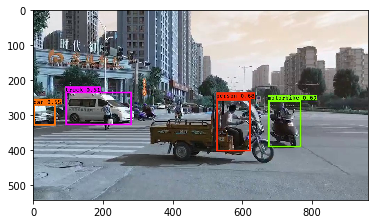

In [46]:
import os 
import cv2
videoCapture = cv2.VideoCapture('gym.mp4')
fourcc = cv2.VideoWriter_fourcc(*'8BPS')
fps = videoCapture.get(cv2.CAP_PROP_FPS)
size = (int(videoCapture.get(cv2.CAP_PROP_FRAME_WIDTH)), 
        int(videoCapture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fNUMS = videoCapture.get(cv2.CAP_PROP_FRAME_COUNT)
videoWriter = cv2.VideoWriter('oto_other0.avi', fourcc, fps , size)
success, img = videoCapture.read() 
while  success:
    success, img = videoCapture.read()
    img = Image.fromarray(img.astype('uint8')).convert('RGB')
    a = "out_test.jpg"
    img.save(os.path.join("images", a ), quality = 100)
    out_scores, out_boxes, out_classes = predict(sess, a)
    pic = cv2.imread("out/"+a)
    pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
    pic = np.asarray(pic)
    cv2.imshow("Windows", pic)
    videoWriter.write(pic)
    if cv2.waitKey(100) & 0xff == ord('q'):.
        break
cv2.destroyAllWindows()


In [ ]:
capture = cv2.VideoCapture('1st.mp4')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
videoWriter = cv2.VideoWriter('oto_other.mp4', fourcc , (680, 480)) 
while success:
    result, img =  success:capture.read()
 #   img = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    img = Image.fromarray(img.astype('uint8')).convert('RGB')
#    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    a = "out_test.jpg"
    img.save(os.path.join("images", a ), quality = 100)
#    img = Image.fromarray(img)
    image = predict(sess, a)
    print(image)
 #   videoWriter.write(frame)
    if cv2.waitKey(100) & 0xff == ord('q'):
        break
cv2.destroyAllWindows()


In [29]:
import os 
import cv2
videoCapture = cv2.VideoCapture('1st.mp4')
fourcc = cv2.VideoWriter_fourcc(*'8BPS')
fps = videoCapture.get(cv2.CAP_PROP_FPS)
size = (int(videoCapture.get(cv2.CAP_PROP_FRAME_WIDTH)), 
        int(videoCapture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fNUMS = videoCapture.get(cv2.CAP_PROP_FRAME_COUNT)
videoWriter = cv2.VideoWriter('oto_other1.avi', fourcc, fps , size)
success, frame = videoCapture.read()
while success:
    result, frame = videoCapture.read()
    videoWriter.write(frame)
    cv2.imshow("Windows",frame)
    cv2.waitKey(5)
    success, frame = videoCapture.read()

#destroyallWindows()

    
    

In [21]:
a = "hrx2.jpg"
import PIL.Image as Image
import numpy as np
pic = Image.open("preimages/"+a)
pic = pic.resize((1280,720))
pic = np.asarray(pic)
print(pic)

[[[165 134 132]
  [149  90  94]
  [152  87  93]
  ...
  [220 190 179]
  [223 190 181]
  [217 183 174]]

 [[143  68  47]
  [154  71  55]
  [163  76  66]
  ...
  [216 196 187]
  [218 198 191]
  [222 198 194]]

 [[133  57  34]
  [140  57  43]
  [146  59  50]
  ...
  [210 196 185]
  [210 196 187]
  [210 195 188]]

 ...

 [[217 191 178]
  [219 193 180]
  [213 190 176]
  ...
  [ 34  23  19]
  [ 44  30  27]
  [ 35  20  17]]

 [[220 194 181]
  [215 189 176]
  [211 188 174]
  ...
  [ 33  22  18]
  [ 41  27  24]
  [ 27  12   9]]

 [[215 189 176]
  [216 190 177]
  [208 185 171]
  ...
  [ 32  23  18]
  [ 32  21  15]
  [ 31  18  12]]]


In [ ]:
a = cv2.imread(a)

In [ ]:
import cv2 as cv2


In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'8BPS')